# EL Analysis FINAL

This Jypyter notebook is mainly the cleaned version of previous raw works.

In [195]:
# from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.datasets import mnist
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import matplotlib.image as matimg
import skimage
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_nl_means, estimate_sigma, denoise_wavelet
from skimage import data, img_as_float
from skimage import measure
from skimage import util 
import skimage.feature
import skimage.viewer
from copy import deepcopy
import random
from numpy import asarray
from skimage.metrics import structural_similarity as ssim
from matplotlib.pyplot import savefig
import os,sys
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.models import Model

#Load and show an image with Pillow
from PIL import Image

from scipy import ndimage as ndi
from skimage import feature
from skimage import filters

In [196]:
# Image Plotting function
def plot_func(images, saveimage, x=3,y=4, cmap='gray', savename=''):
    plt.figure(figsize=(15,15))
    for i in range(len(images)):
        ax = plt.subplot(x,y,i+1)
        plt.imshow(images[i], cmap = cmap)
    
    #plt.imshow(image, cmap = 'gray')
        
    if(saveimage==True):
        plt.savefig(savename, bbox_inches='tight', format = 'png')

In [197]:
def barrel_dist(med):
    # Barrel Filtering

    src    = med
    width  = src.shape[1]
    height = src.shape[0]

    distCoeff = np.zeros((4,1),np.float64)

    # TODO: add your coefficients here!
    k1 = -1.5e-5;  #negative to remove barrel distortion
    k2 = 0.0 ; #-1.0e-8;
    p1 = 0.0;
    p2 = 0.0;

    distCoeff[0,0] = k1;
    distCoeff[1,0] = k2;
    distCoeff[2,0] = p1;
    distCoeff[3,0] = p2;

    # assume unit matrix for camera
    cam = np.eye(3,dtype=np.float32)

    cam[0,2] = width/2.0  # define center x
    cam[1,2] = height/2.0 # define center y
    cam[0,0] = 10.        # define focal length x
    cam[1,1] = 10.        # define focal length y

    # here the undistortion will be computed
    img_corr = cv2.undistort(src,cam,distCoeff)

    #cv2.imshow('Undistorted', img_corr)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    return(img_corr)


In [200]:
def preprocessing(raw_image, bg_image):
    
    # Get net image by subtracting raw image from background image 
    net_image = cv2.subtract(raw_image,bg_image)
    
    # Compare the raw image with net image using SSIM
    ssim_cv2 = ssim(raw_image, net_image, multichannel = True )
    print(ssim_cv2)
    
    # Remove salt and pepper noise using median filter
    med = ndimage.median_filter(net_image, 3)
    
    # Remove barrel distortion to make the image flatter
    corrected = barrel_dist(med)
    
    # Loosely crop the image
    #cropped = Corrected[32:604, 15:883]
    
    return corrected

Note: Images are not being cropped in this document

In [201]:
root1 = "REC_Panel/"
root2 = "REC_Background/"

raw_image = []
bg_image = []

for filename in os.listdir(root1):
    #print(filename)
    raw_image.append(cv2.imread('REC_Panel/{0}'.format(filename),0))

for filename in os.listdir(root2):
    #print('BG', filename)
    bg_image.append(cv2.imread('REC_Background/{0}'.format(filename),0))



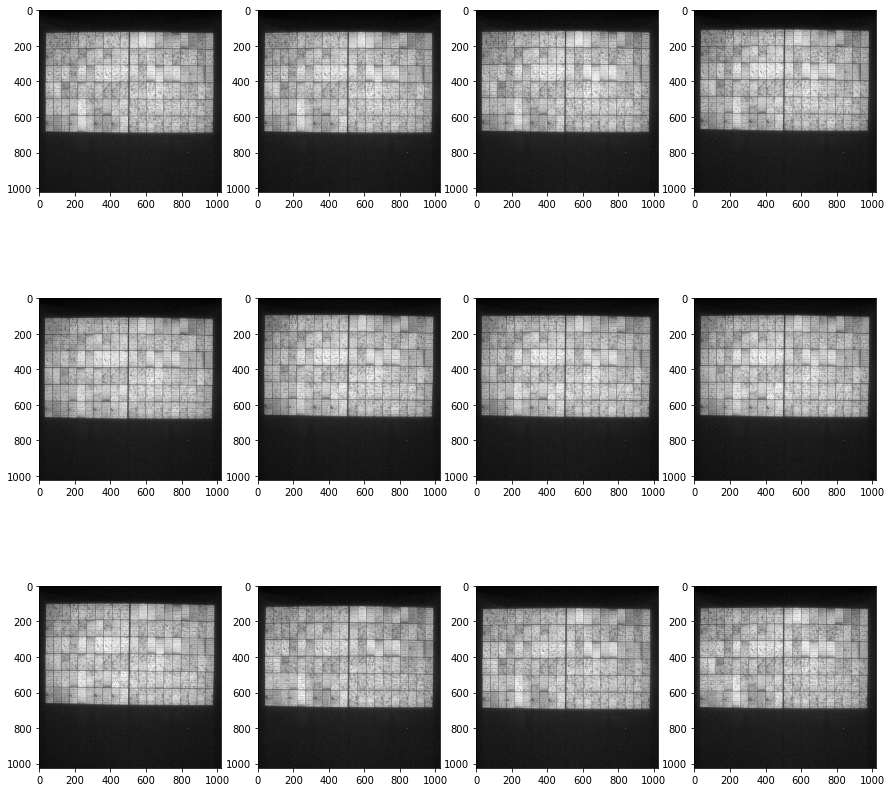

In [202]:
# Plotting the raw images

plot_func(raw_image, saveimage = False, x=3, y=4)

In [203]:
# Preprocessing the raw images

ready_img = []
for i in range(len(raw_image)):
    ready_img.append(preprocessing(raw_image[i], bg_image[i]))

# Below are the SSIM values of all raw images with their corresponding net images

0.3392890633452815
0.34597746436161475
0.34582729171461923
0.3473073383198254
0.30497652013492127
0.3515032752072181
0.3100633767243094
0.3295340124295112
0.35331900008957456
0.29987085783097533
0.31277357769453795
0.3276510924597013


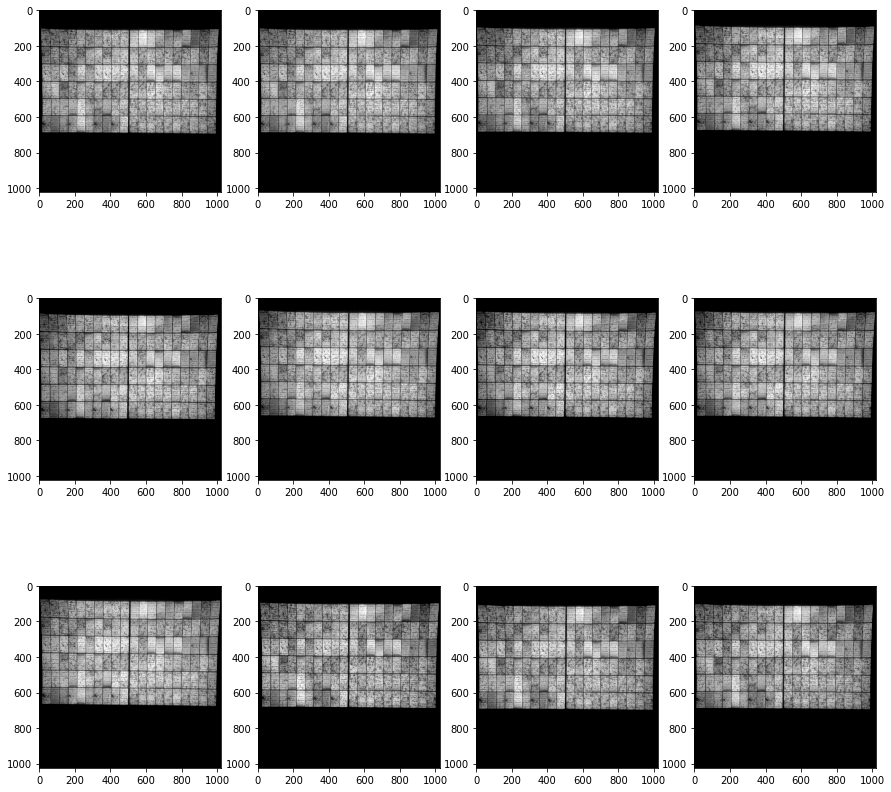

In [204]:
# Plotting the preprocessed images

plot_func(ready_img, saveimage = False, x=3, y=4)

In [205]:
# Since there is no cropping, all images are in their real shape

ready_img[0].shape

(1024, 1024)

# Autoencoder

In [206]:
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

In [207]:
# Putting first 6 month's images in training dataset and next 6 month's images in testing dataset

x_train = []
x_test = []

for i in range(12):
    if i<6:
        x_train.append(ready_img[i])
    else:
        x_test.append(ready_img[i])
    
print(len(x_train))
print(len(x_test))

6
6


In [208]:
# To check whether the images are different or same

comparison = x_train[1]==x_train[2]
print(comparison.all())

False


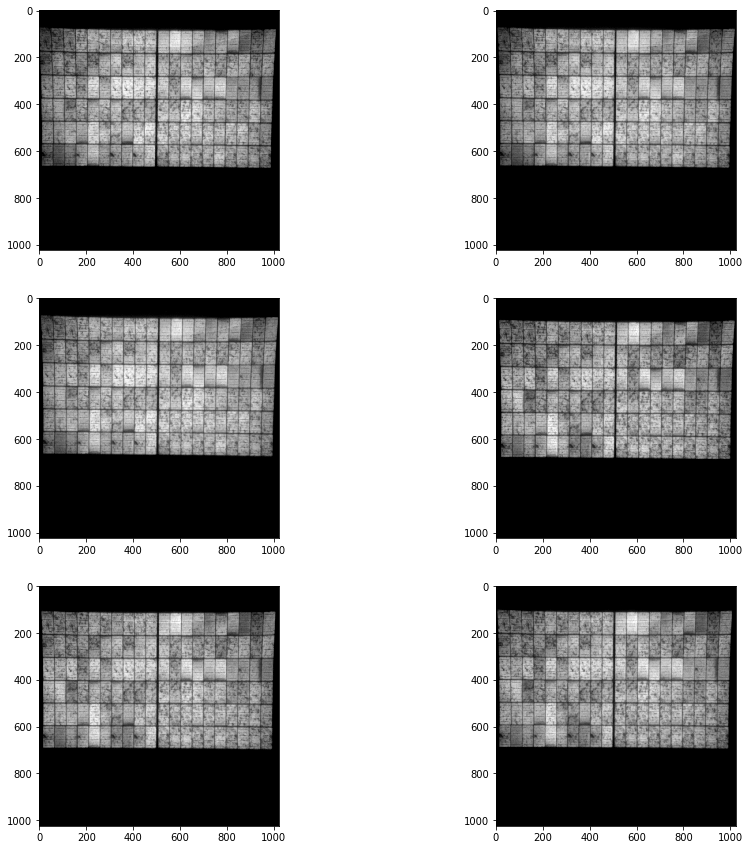

In [209]:
# Plotting the test images

plot_func(x_test, saveimage = False, x = 3, y = 2)

In [210]:
# Shape of training and testing data

print(x_train[1].shape)
print(x_test[1].shape)

(1024, 1024)
(1024, 1024)


In [211]:
# Converting list to array

x_train = np.array(x_train)
x_test = np.array(x_test)

In [212]:
x_train.shape

(6, 1024, 1024)

In [213]:
# Reshaping data to for autoencoder and normalizing the values within 0 and 1

x_train = np.reshape(x_train, (len(x_train), 1024, 1024, 1))
x_test = np.reshape(x_test, (len(x_test), 1024, 1024, 1))

x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.

print('X_train shape:', x_train.shape)
print('X_test shape:', x_test.shape)

X_train shape: (6, 1024, 1024, 1)
X_test shape: (6, 1024, 1024, 1)


In [214]:
# For denoining autoencoder (anomaly/novel detection) some contamination factor is used

noise_factor = 0.015
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

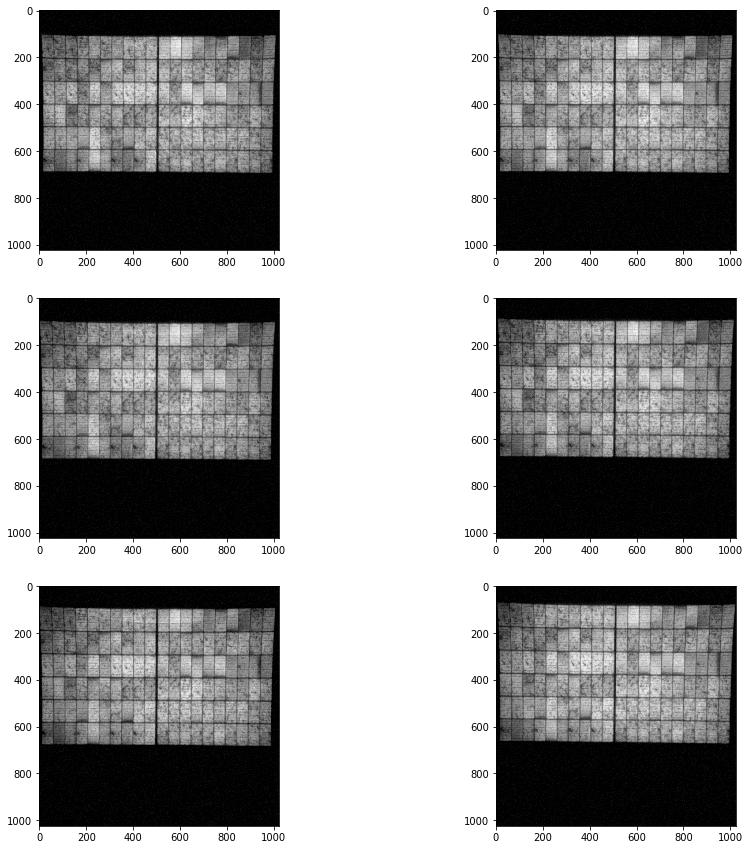

In [215]:
# Plotting noisy data

plot_func(x_train_noisy.reshape(6,1024,1024), saveimage = False, x = 3, y = 2)

In [224]:
# Creating the model

#model = Sequential()
input_img = Input(shape=(1024, 1024,1))

# Encoding (or Compressing) images
x = Conv2D(32,(3,3), activation = 'relu', padding = 'same')(input_img) #input_shape = (574, 877, 1)))
#model.add(Conv2D(1000,(3,3), activation = 'relu', padding = 'same'))

x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(32,(3,3), activation = 'relu', padding = 'same')(x)

x = MaxPooling2D((2,2), padding = 'same')(x)

x = Conv2D(8,(3,3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2,2), padding = 'same')(x)

# Decoding (or Decompressing) images
x = Conv2D(8,(3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32,(3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32,(3,3), activation = 'relu', padding='same')(x)
x = UpSampling2D((2,2))(x)

decoded = Conv2D(1,(3,3), activation = 'relu', padding = 'same')(x)


model = Model(input_img, decoded)

model.compile(optimizer='adam', loss = 'mean_squared_error')

model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1024, 1024, 1)     0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 1024, 1024, 32)    320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 512, 512, 32)      9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 256, 256, 8)       2312      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 128, 128, 8)       0   

In [225]:
# Fitting training samples to the model

epochs = 15
batch_size = 500

history = model.fit(x_train_noisy, x_train, batch_size=batch_size, epochs = epochs, verbose=1, validation_data=(x_test_noisy, x_test))

Train on 6 samples, validate on 6 samples
Epoch 1/15
6/6 [==============================] - 45s 8s/step - loss: 0.0603 - val_loss: 0.0407
Epoch 2/15
6/6 [==============================] - 46s 8s/step - loss: 0.0449 - val_loss: 0.0289
Epoch 3/15
6/6 [==============================] - 40s 7s/step - loss: 0.0321 - val_loss: 0.0156
Epoch 4/15
6/6 [==============================] - 46s 8s/step - loss: 0.0175 - val_loss: 0.0058
Epoch 5/15
6/6 [==============================] - 34s 6s/step - loss: 0.0062 - val_loss: 0.0124
Epoch 6/15
6/6 [==============================] - 39s 6s/step - loss: 0.0122 - val_loss: 0.0179
Epoch 7/15
6/6 [==============================] - 37s 6s/step - loss: 0.0179 - val_loss: 0.0113
Epoch 8/15
6/6 [==============================] - 26s 4s/step - loss: 0.0112 - val_loss: 0.0054
Epoch 9/15
6/6 [==============================] - 26s 4s/step - loss: 0.0053 - val_loss: 0.0041
Epoch 10/15
6/6 [==============================] - 27s 5s/step - loss: 0.0043 - val_loss: 0.00

Onservation: Training loss and Validation loss is decreasing, which means the model is learning

Note 1: I tried ADAM optimiser, which did mot work as good as SGD

Note 2: Image size (i.e., 1024x1024) currently is very large and hence the model is taking much time to learn, whereas, on cropping it might take less time. 

Note 3: In future, with more no. of epochs, it can work better if run on GPU.

In [226]:
# Predicting outcome on input data

pred = model.predict(x_test_noisy)

In [227]:
# Calculating mean squared error

mse = np.sum(np.power(x_test - pred, 2), axis=1)

In [228]:
# Bring data back to grayscale

pred = pred*255
pred = pred.astype(np.uint8)

In [229]:
# Checking for data type

pred.reshape(6,1024,1024)[0][9][9].dtype

dtype('uint8')

[[[3 3 3 ... 3 3 2]
  [4 4 4 ... 4 4 2]
  [5 5 5 ... 5 5 3]
  ...
  [4 5 5 ... 5 4 2]
  [4 5 5 ... 5 4 2]
  [3 4 4 ... 4 3 2]]

 [[3 3 3 ... 3 3 2]
  [4 4 4 ... 4 4 2]
  [4 5 5 ... 5 5 3]
  ...
  [5 5 5 ... 5 4 2]
  [4 5 5 ... 5 4 2]
  [3 4 4 ... 4 3 2]]

 [[3 3 3 ... 3 3 2]
  [4 4 4 ... 4 4 2]
  [4 5 5 ... 5 5 3]
  ...
  [5 5 5 ... 5 4 2]
  [4 5 5 ... 5 4 2]
  [3 4 4 ... 4 3 2]]

 [[3 3 3 ... 3 3 2]
  [4 4 4 ... 4 4 2]
  [4 5 5 ... 5 5 3]
  ...
  [5 5 5 ... 5 4 2]
  [4 5 5 ... 5 4 2]
  [3 4 4 ... 4 3 2]]

 [[3 3 3 ... 3 3 2]
  [4 4 4 ... 4 4 2]
  [4 5 5 ... 5 5 3]
  ...
  [5 5 5 ... 5 4 2]
  [4 5 5 ... 5 4 2]
  [3 4 4 ... 4 3 2]]

 [[3 3 3 ... 3 3 2]
  [4 4 4 ... 4 4 2]
  [4 5 5 ... 5 5 3]
  ...
  [4 5 5 ... 5 4 2]
  [4 5 5 ... 5 4 2]
  [3 4 4 ... 4 3 2]]]


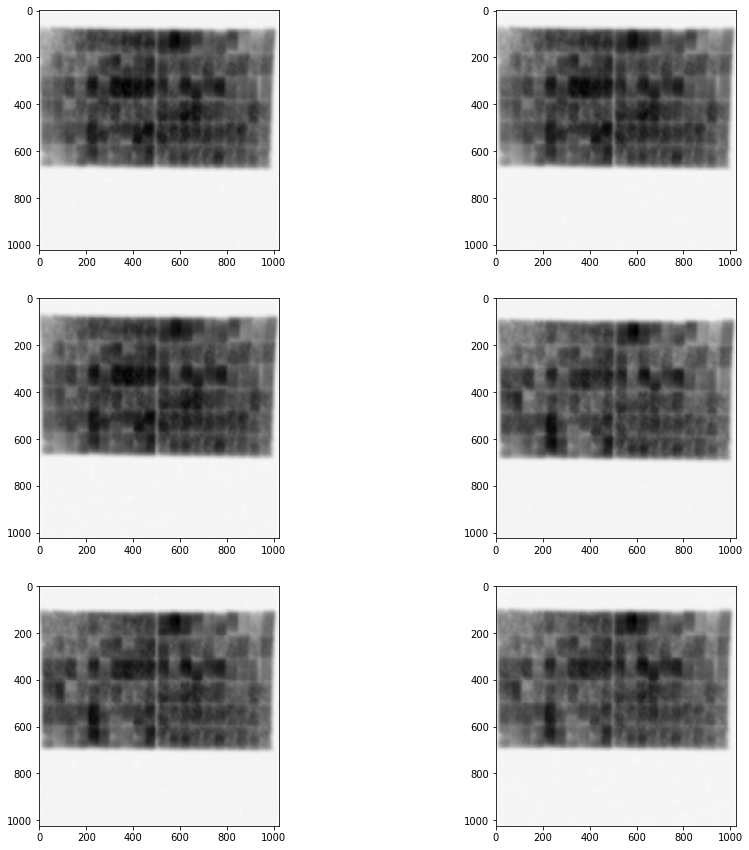

In [230]:
#Printing values of testing data and plotting the prediction

print(pred.reshape(6,1024,1024))
plot_func(pred.reshape(6,1024,1024), saveimage = False, x=3, y=2, cmap='binary')

Note: Autoencoder is functional. Output gets better with large sample size and more epochs. Further work can be done in order to optimize Anomaly Detection.
Note: One can definitely play around with parameters to improvise the working of Autoencoder.